# **PART 0: RLIBS SETUP**

Load R magic extension & Mount Google Drive

In [ ]:
%load_ext rpy2.ipython
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Setup Google Drive directory to R package library

In [ ]:
%%R
.libPaths("/content/drive/MyDrive/R_ggColab_Thien/Rlibs")

Load required libraries

In [ ]:
%%R
library(DMRcate)
library(data.table)
library(tidyverse)
library(qs)
library(knitr)
library(ggplot2)
library(qqman)
library(pheatmap)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)

data.table 1.17.0 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com
qs 0.27.3. Announcement: https://github.com/qsbase/qs/issues/103

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.



Global setup

In [ ]:
%%R
set.seed(123)
Sys.setenv("VROOM_CONNECTION_SIZE" = 131072 * 1000)  # Increase buffer size
options(timeout = 3600)  # Increase timeout for slow GEO servers

Directory setup

In [ ]:
%%R
gse_acc <- "GSE169622"
dir_op <- file.path("/content/drive/MyDrive/R_ggColab_Thien", gse_acc)
setwd(dir_op)

dir_op.raw <- file.path(dir_op, "01.Raw")
dir_op.qc <- file.path(dir_op, "02.QC")
dir_op.methProbes <- file.path(dir_op, "03.methProbes")

dir_op.dmrcate <- file.path(dir_op, "04.DMRcate_results")
if (!dir.exists(dir_op.dmrcate)) {dir.create(dir_op.dmrcate)}


# **PART 1: DATA PREPARATION**

Load metadata

In [ ]:
%%R
metaDT_Sub <- fread(file.path(dir_op.raw, "Metadata_Sub.csv"), header = TRUE, data.table = FALSE)
print(kable(head(metaDT_Sub)))



|title                              |source_name_ch1         |diseasestate    |gender |hpvtype  |sampletype |supplementary_file                                                                                            |supplementary_file.1                                                                                          |Accession_number |
|:----------------------------------|:-----------------------|:---------------|:------|:--------|:----------|:-------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------|:----------------|
|SAMPLE_1:_normal_cervical_sample_1 |genomic_DNA_from_FFPE_1 |normal          |Female |negative |FFPE       |ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211145/suppl/GSM5211145_201328710023_R01C01_Grn.idat.gz |ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5211nnn/GSM5211145/suppl/GSM5211145_

Load methylation matrix

In [ ]:
%%R
bVals <- fread(file.path(dir_op.methProbes, "bigTable.hg19.tsv"), header = TRUE, data.table = FALSE, sep = "\t")
rownames(bVals) <- bVals$probeID
print(kable(head(bVals)))



|           |probeID    |seqnames |     start|       end| width|strand | SAMPLE_1:_normal_cervical_sample_1| SAMPLE_2:_normal_cervical_sample_2| SAMPLE_3:_normal_cervical_sample_3| SAMPLE_4:_cervical_cancer_1| SAMPLE_5:_cervical_cancer_2| SAMPLE_6:_cervical_cancer_3| SAMPLE_7:_cervical_cancer_4| SAMPLE_8:_cervical_cancer_5| SAMPLE_9:_cervical_cancer_6|
|:----------|:----------|:--------|---------:|---------:|-----:|:------|----------------------------------:|----------------------------------:|----------------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|
|cg00000165 |cg00000165 |chr1     |  91194674|  91194674|     1|*      |                               0.18|                               0.16|                               0.17|                        0.38|                        0.53|                        0.70|                     

|--------------------------------------------------|
|==================================================|


Load DMRs ranking

In [ ]:
%%R
DMRs <- qread(file = file.path(dir_op.dmrcate, "DMRrange.hg19.RDS"))
print(DMRs)

GRanges object with 1866 ranges and 8 metadata columns:
         seqnames              ranges strand |   no.cpgs min_smoothed_fdr
            <Rle>           <IRanges>  <Rle> | <integer>        <numeric>
     [1]     chr6 166579057-166583523      * |        24      0.00000e+00
     [2]     chr2 107501733-107504523      * |        21     1.41421e-286
     [3]     chr6   28602513-28603779      * |        36     3.04122e-265
     [4]     chr2 155553986-155556321      * |        19     1.73675e-219
     [5]     chr6     7248862-7248983      * |         3     6.13891e-217
     ...      ...                 ...    ... .       ...              ...
  [1862]     chr2 131673894-131673963      * |         2      6.93068e-09
  [1863]     chr2   32502781-32502885      * |         3      7.03749e-09
  [1864]     chrX   55291317-55291412      * |         4      7.07747e-09
  [1865]     chr2 220381808-220381812      * |         2      7.30589e-09
  [1866]     chr6 151713355-151713358      * |         2

Load DMPs ranking

In [ ]:
%%R
myannotation <- qread(file = file.path(dir_op.dmrcate, "cpg.annotate.RDS"))
DMPs <- fread(file.path(dir_op.dmrcate, "/DMP.hg19.tsv"), sep = "\t")
print(kable(head(DMPs)))



|probeID    |seqnames |  start|    end| width|strand |      stat|      diff|   rawpval|   ind.fdr|is.sig |      delta|
|:----------|:--------|------:|------:|-----:|:------|---------:|---------:|---------:|---------:|:------|----------:|
|cg00000721 |chr6     | 180746| 180746|     1|*      | 0.9012311| 0.0283333| 0.3867264| 0.5710729|FALSE  | -0.0183333|
|cg00001594 |chr2     |  42968|  42968|     1|*      | 1.2578404| 0.0983333| 0.2344339| 0.4171879|FALSE  | -0.0250000|
|cg00001747 |chr2     |  42998|  42998|     1|*      | 2.9342643| 0.1700000| 0.0135542| 0.0730710|FALSE  |  0.4066667|
|cg00001791 |chr2     |  43812|  43812|     1|*      | 1.9098396| 0.1300000| 0.0824981| 0.2162358|FALSE  |  0.0216667|
|cg00001814 |chr2     |  43953|  43953|     1|*      | 1.1725909| 0.0916667| 0.2656693| 0.4509825|FALSE  | -0.1266667|
|cg00002145 |chr2     |  45264|  45264|     1|*      | 0.7115608| 0.0316667| 0.4915161| 0.6625920|FALSE  |  0.0383333|


In [ ]:
%%R
DMPs <- DMPs %>%
  mutate(pi_value = -log10(ind.fdr) * diff,
         regulation = case_when(
             ind.fdr < 0.05 & diff >= 0.1 ~ "Hypermethylated",
             ind.fdr < 0.05 & diff <= -0.1 ~ "Hypomethylated",
             TRUE ~ "Insignificant")
  ) %>%
  arrange(desc(pi_value))

## Subset top 10 up- and down-regulated
DMPs_hyper <- DMPs %>%
  filter(regulation == "Hypermethylated") %>%
  top_n(n = 50, wt = pi_value) %>%
  pull(probeID)

DMPs_hypo <- DMPs %>%
filter(regulation == "Hypomethylated") %>%
top_n(n = -50, wt = pi_value) %>%
pull(probeID)


In [ ]:
%%R
print(DMPs_hyper)
print(DMPs_hypo)

 [1] "cg01615880" "cg19257543" "cg23627145" "cg16805117" "cg13867747"
 [6] "cg05109300" "cg01897594" "cg07347963" "cg19246007" "cg04277076"
[11] "cg05438353" "cg05177437" "cg22866681" "cg06736678" "cg00907461"
[16] "cg05946856" "cg18438461" "cg20486052" "cg11206634" "cg06850509"
[21] "cg20515206" "cg20869158" "cg12093270" "cg21129864" "cg20313628"
[26] "cg26287783" "cg05296990" "cg18861762" "cg01016040" "cg10725229"
[31] "cg09064094" "cg04276508" "cg07535850" "cg07536187" "cg23906876"
[36] "cg06832138" "cg11743670" "cg14954595" "cg06362432" "cg04276715"
[41] "cg20899383" "cg06284878" "cg09863248" "cg13012015" "cg02786257"
[46] "cg04275695" "cg20208184" "cg15982130" "cg13870435" "cg02801193"
 [1] "cg15707064" "cg12592908" "cg23281307" "cg04445772" "cg09545452"
 [6] "cg12170514" "cg00609295" "cg12127282" "cg16985249" "cg19177744"
[11] "cg12126471" "cg16984992" "cg21146015" "cg10953326" "cg05812657"
[16] "cg25907322" "cg12168100" "cg23281123" "cg25736986" "cg14961809"
[21] "cg00936853" "c

In [ ]:
%%R
top100_cpg <- c(DMPs_hyper, DMPs_hypo)
DMPs_top100 <- bVals[top100_cpg, metaDT_Sub$title]
print(kable(head(DMPs_top100)))



|           | SAMPLE_1:_normal_cervical_sample_1| SAMPLE_2:_normal_cervical_sample_2| SAMPLE_3:_normal_cervical_sample_3| SAMPLE_4:_cervical_cancer_1| SAMPLE_5:_cervical_cancer_2| SAMPLE_6:_cervical_cancer_3| SAMPLE_7:_cervical_cancer_4| SAMPLE_8:_cervical_cancer_5| SAMPLE_9:_cervical_cancer_6|
|:----------|----------------------------------:|----------------------------------:|----------------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|---------------------------:|
|cg01615880 |                               0.16|                               0.20|                               0.14|                        0.27|                        0.38|                        0.48|                        0.13|                        0.28|                        0.48|
|cg19257543 |                               0.19|                               0.15|                         

# **PART 2: MANHATTAN PLOT**

>A Manhattan plot is commonly used in genome-wide studies to visualize the significance of CpG sites or genetic variants across the genome. In DNA methylation analysis, each point represents a CpG site, with the x-axis showing its genomic position (organized by chromosome) and the y-axis showing the negative log10 of the p-value from a differential test. Peaks in the plot indicate regions with highly significant differential methylation. This plot is useful for identifying clusters of CpGs—potential differentially methylated regions (DMRs)—that may be associated with disease or experimental conditions.

In [ ]:
%%R
manhattan_df <- DMPs
manhattan_df$seqnames <- gsub("chrX", "chr23", manhattan_df$seqnames)
manhattan_df$seqnames <- gsub("chrY", "chr24", manhattan_df$seqnames)
manhattan_df$seqnames <- gsub("chrMT", "chr25", manhattan_df$seqnames)
manhattan_df$CHR <- as.numeric(gsub("chr", "", manhattan_df$seqnames))

print(kable(head(manhattan_df)))



|probeID    |seqnames |     start|       end| width|strand |      stat|      diff| rawpval|   ind.fdr|is.sig |      delta| pi_value|regulation      | CHR|
|:----------|:--------|---------:|---------:|-----:|:------|---------:|---------:|-------:|---------:|:------|----------:|--------:|:---------------|---:|
|cg01615880 |chr6     |   8743589|   8743589|     1|*      | 10.509556| 0.4000000| 4.0e-07| 0.0007090|TRUE   |  0.1700000| 1.259736|Hypermethylated |   6|
|cg19257543 |chr6     | 116786636| 116786636|     1|*      |  8.632892| 0.4583333| 3.1e-06| 0.0018387|TRUE   |  0.0566667| 1.253767|Hypermethylated |   6|
|cg23627145 |chr2     | 226329535| 226329535|     1|*      |  9.176766| 0.4200000| 1.7e-06| 0.0013447|TRUE   | -0.0850000| 1.205974|Hypermethylated |   2|
|cg16805117 |chr6     |  90813309|  90813309|     1|*      |  9.857484| 0.3833333| 8.0e-07| 0.0009033|TRUE   |  0.0733333| 1.166931|Hypermethylated |   6|
|cg13867747 |chr2     | 125044021| 125044021|     1|*      | 10.0881

In addition: Warning message:
In manhattan(x = manhattan_df, chr = "CHR", bp = "start", p = "rawpval",  :
  You're trying to highlight SNPs that don't exist in your results.


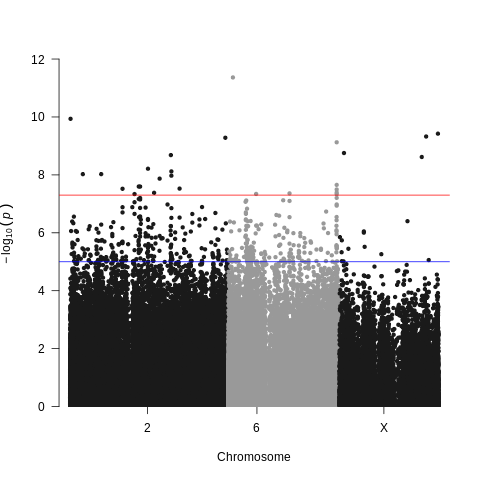

In [ ]:
%%R
manhattan(
  x = manhattan_df,
  chr = "CHR",
  bp = "start",
  p = "rawpval",
  snp = "probeID",
  chrlabs = c(2, 6, "X"),
  suggestiveline = -log10(1e-05),
  genomewideline = -log10(5e-08),
  highlight = DMPs_top100,
  logp = TRUE
)

# **PART 3: VOLCANO PLOT**

>A volcano plot combines statistical significance with biological effect size to highlight important changes in DNA methylation or gene expression. The x-axis usually shows the log2 fold change, representing the magnitude and direction of the change, while the y-axis shows the negative log10 of the p-value, representing statistical significance. This layout helps identify CpG sites or genes that are both statistically significant and biologically meaningful—typically those in the top left and right corners of the plot. Volcano plots are quick visual summaries of differential analysis results.

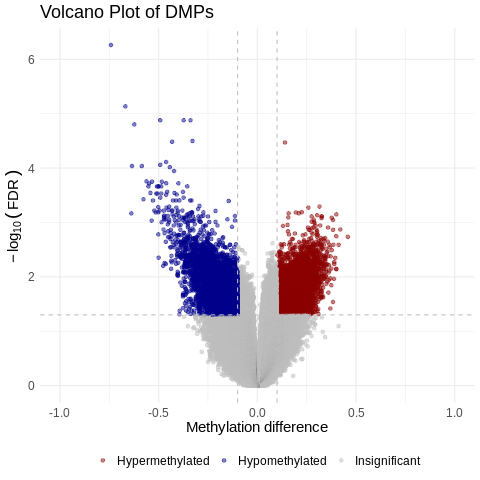

In [ ]:
%%R
ggplot(DMPs,
       aes(x = diff,
           y = -log10(ind.fdr),
           color = regulation)) +
  geom_point(alpha = 0.5) +
  geom_vline(xintercept = c(-0.1, 0.1), col = "gray", linetype = 'dashed') +
  geom_hline(yintercept = -log10(0.05), col = "gray", linetype = 'dashed') +
  scale_color_manual(values = c("darkred", "darkblue", "grey")) +
  xlim(-1, 1) +
  labs(title = "Volcano Plot of DMPs",
       x = "Methylation difference",
       y = expression(-log[10](paste("FDR"))),
       color = NULL) +
  theme_minimal() +
  theme(legend.position = "bottom",
        text = element_text(size = 15))


# **PART 4: PCA PLOT**

>Principal Component Analysis (PCA) is a dimensionality reduction technique that summarizes complex datasets into principal components that capture the most variance. In a PCA plot, each point represents a sample, and the axes correspond to the first two principal components (PC1 and PC2). This plot helps assess sample similarity, identify batch effects, or detect outliers. In methylation or gene expression analysis, PCA is often used in quality control or exploratory steps to determine whether samples cluster according to biological conditions (e.g., disease vs. control).

In [ ]:
%%R
pca <- prcomp(t(DMPs_top100), scale. = TRUE)
pca_df <- as.data.frame(pca$x)
pca_df$diseasestate <- metaDT_Sub$diseasestate
pca_df$hpvtype <- metaDT_Sub$hpvtype
print(kable(head(pca_df)))



|                                   |        PC1|        PC2|        PC3|        PC4|        PC5|        PC6|        PC7|        PC8| PC9|diseasestate    |hpvtype  |
|:----------------------------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---:|:---------------|:--------|
|SAMPLE_1:_normal_cervical_sample_1 |  -5.438090|  1.7293682|  0.4033129|  3.5288782| -4.2897600|  2.7869845|  0.4166000| -1.4888099|   0|normal          |negative |
|SAMPLE_2:_normal_cervical_sample_2 | -10.690250|  0.1342672|  0.0711578| -1.2732983|  4.2449282|  0.4040795| -0.6716156| -1.5329331|   0|normal          |negative |
|SAMPLE_3:_normal_cervical_sample_3 |  -5.905406| -0.1094320| -0.2766254|  0.0501716| -1.5293106| -3.1754718|  0.4537548|  4.0822269|   0|normal          |negative |
|SAMPLE_4:_cervical_cancer_1        |   3.344537| -1.8299923|  3.3870930|  1.0129986| -0.7924357| -4.6187856| -0.7400388| -2.9016184|   0|cervical_cancer |HPV18    |
|S

Scree plot of PCA

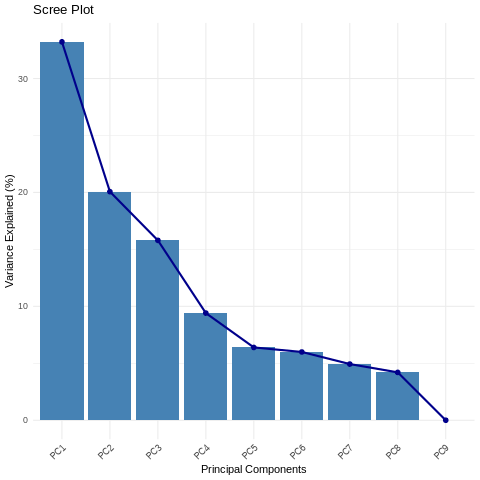

In [ ]:
%%R
explained_var <- pca$sdev^2 / sum(pca$sdev^2) * 100  # Percent variance explained
scree_df <- data.frame(PC = paste0("PC", 1:length(explained_var)),
                       Variance = explained_var)

ggplot(scree_df, aes(x = PC, y = Variance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_line(aes(group = 1), color = "darkblue", linewidth = 1) +
  geom_point(color = "darkblue", size = 2) +
  labs(title = "Scree Plot", x = "Principal Components", y = "Variance Explained (%)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

PCA scatter plot

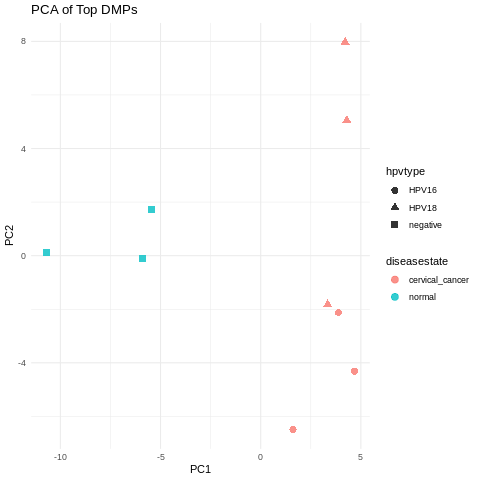

In [ ]:
%%R
ggplot(pca_df, aes(x = PC1, y = PC2, color = diseasestate, shape = hpvtype)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(title = "PCA of Top DMPs", x = "PC1", y = "PC2") +
  theme_minimal()

# **PART 5: HEATMAP**

>A heatmap provides a high-resolution view of methylation or gene expression levels across multiple samples and features (e.g., CpGs or genes). Each cell in the heatmap is color-coded to represent a value such as a methylation beta value, allowing for quick visual comparison. Heatmaps are often clustered by rows (features) and/or columns (samples), revealing underlying patterns and groupings, such as sample subtypes or treatment responses. They are especially useful for visualizing sets of differentially methylated position (DMPs) or differentially expressed genes (DEGs).

In [ ]:
%%R
annotation_col <- data.frame(Group = metaDT_Sub$diseasestate)
rownames(annotation_col) <- colnames(DMPs_top100)
print(kable(head(annotation_col)))



|                                   |Group           |
|:----------------------------------|:---------------|
|SAMPLE_1:_normal_cervical_sample_1 |normal          |
|SAMPLE_2:_normal_cervical_sample_2 |normal          |
|SAMPLE_3:_normal_cervical_sample_3 |normal          |
|SAMPLE_4:_cervical_cancer_1        |cervical_cancer |
|SAMPLE_5:_cervical_cancer_2        |cervical_cancer |
|SAMPLE_6:_cervical_cancer_3        |cervical_cancer |


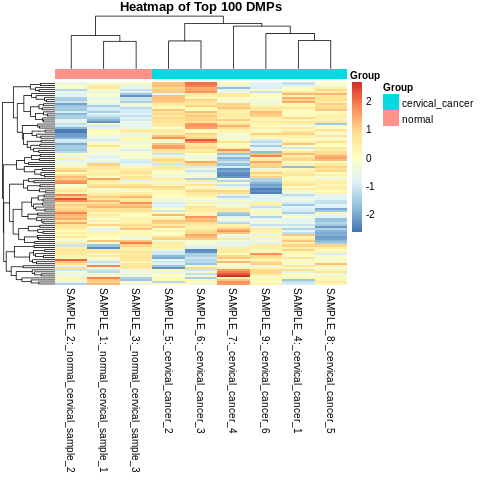

In [ ]:
%%R
pheatmap(DMPs_top100, scale = "row", annotation_col = annotation_col,
         clustering_distance_rows = "euclidean",
         clustering_distance_cols = "euclidean",
         show_rownames = FALSE,
         main = "Heatmap of Top 100 DMPs")

# **PART 6: DMR PLOT**

In [ ]:
%%R
type <- factor(metaDT_Sub$diseasestate)
groups <- c(cervical_cancer = "magenta", normal = "forestgreen")
cols <- groups[as.character(type)]
cols

         normal          normal          normal cervical_cancer cervical_cancer 
  "forestgreen"   "forestgreen"   "forestgreen"       "magenta"       "magenta" 
cervical_cancer cervical_cancer cervical_cancer cervical_cancer 
      "magenta"       "magenta"       "magenta"       "magenta" 


In [ ]:
%%R
DMRs[1:10]

GRanges object with 10 ranges and 8 metadata columns:
       seqnames              ranges strand |   no.cpgs min_smoothed_fdr
          <Rle>           <IRanges>  <Rle> | <integer>        <numeric>
   [1]     chr6 166579057-166583523      * |        24      0.00000e+00
   [2]     chr2 107501733-107504523      * |        21     1.41421e-286
   [3]     chr6   28602513-28603779      * |        36     3.04122e-265
   [4]     chr2 155553986-155556321      * |        19     1.73675e-219
   [5]     chr6     7248862-7248983      * |         3     6.13891e-217
   [6]     chr2   80529547-80532937      * |        26     8.77349e-215
   [7]     chr2 154727485-154730326      * |        20     3.44176e-214
   [8]     chr6   29520527-29521803      * |        35     9.73964e-185
   [9]     chr6   94126141-94129636      * |        17     2.02914e-169
  [10]     chr2   47796781-47799268      * |        15     6.75639e-153
           Stouffer       HMFDR      Fisher   maxdiff  meandiff
          <numeric

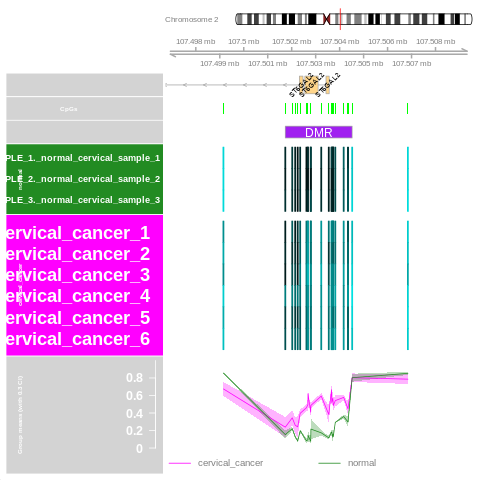

In [ ]:
%%R
DMR.plot(ranges = DMRs, dmr=2, CpGs=myannotation, what="Beta",
         arraytype = "EPICv1", phen.col=cols, genome="hg19")